In [1]:
import math
import os
import pickle
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import logging as log
import torch.nn.functional as F

from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import BCEWithLogitsLoss

from transformers.models.bert.modeling_bert import BertEmbeddings, BertModel, BertPreTrainedModel
from transformers import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report

from tqdm import tqdm, trange

In [2]:
log.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO,
                    filename='bert.log')
logger = log.getLogger('robert.log')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

#### Helper functions to load and save the model

In [4]:
root_folder = '../roberta'

def save_model(model, model_filename, folder=root_folder):
    ''' Save a pytorch model '''
    model_file = os.path.join(folder, model_filename)

    if os.path.exists(model_file):
        os.remove(model_file)

    # Save the model
    torch.save(model.state_dict(), model_file)

def load_model(model_filename, folder=root_folder):
    ''' Load a pytorch model '''
    model_file = os.path.join(folder, model_filename)
    model = torch.load(model_filename)

    if is_cuda:
        model.cuda()

    return model

def remove_last_model(folder, model_filename, config_filename):
    model_file = os.path.join(folder, model_filename)

    if os.path.exists(model_file):
        os.remove(model_file)

    config_file = os.path.join(folder, config_filename)

    if os.path.exists(config_file):
        os.remove(config_file)

def file_exists(filename, folder=root_folder):
    return os.path.exists(os.path.join(folder, filename))

def save_object(filename, obj, folder=root_folder):
    obj_file = os.path.join(folder, filename)

    if os.path.exists(obj_file):
        os.remove(obj_file)

    with open(obj_file, 'wb') as f:
        pickle.dump(obj, f)

def load_object(filename, folder=root_folder):
    object_file = os.path.join(folder, filename)

    with open(object_file, 'rb') as f:
        return pickle.load(f)

#### RoBERTa model creation

In [5]:
model_class = RobertaModel
tokenizer_class = RobertaTokenizer
pretrained_weights = 'roberta-base'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

#### Input (text) processing

In [6]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample."""
        self.text_a = text_a
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, label_ids):
        self.input_ids = input_ids
        self.label_ids = label_ids

In [7]:
def convert_examples_to_features(examples, label_list, tokenizer, max_seq_length):
    """Loads a data file into a list of `InputBatch`s."""
    features = []
    count = 0

    for example in examples:
        tokens_a = tokenizer.tokenize(example.text_a)
        tokens_b = None

        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

        tokens = ['<s>'] + tokens_a + ['</s>']
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding

        assert len(input_ids) == max_seq_length
        
        labels_ids = [float(label) for label in example.labels]
        input_features = InputFeatures(input_ids, labels_ids)
        features.append(input_features)
        
    return features

In [8]:
df = pd.read_parquet('../data/nyt.2000.parquet.gz')
SEED = 17
train, test = train_test_split(df, test_size=.2, random_state=SEED)

In [9]:
print(len(train.Id))
print(len(test.Id))

25716
6430


In [10]:
MAX_SEQ_LENGTH = 100
label_columns = [c for c in train.columns if c not in ['Id', 'Text']]

def get_labels(data, i):
    return data.iloc[i][label_columns]

def create_features(data, tokenizer, max_seq_length=MAX_SEQ_LENGTH):
    logger.info('Processing labels')
    label_list = data[label_columns].values.tolist()
    logger.info('Processing examples')
    examples = (InputExample(i, data.iloc[i].Text, labels=label_list[i]) for i in range(len(data)))
    logger.info('Converting examples to features')

    return convert_examples_to_features(examples, label_list, tokenizer, max_seq_length)

def get_features(data, filename):
    if file_exists(filename):
        features = load_object(filename)
    else:
        tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
        features = create_features(data, tokenizer)
        save_object(filename, features)

    return features

train_features = get_features(train, 'train_roberta_features.pkl')
test_features = get_features(test, 'test_roberta_features.pkl')

In [11]:
class DPCNN(nn.Module):
    def __init__(self, num_labels, channel_size=250, width=768):
        super(DPCNN, self).__init__()
        self.conv_embedding = nn.Conv2d(1, channel_size, (3, width))
        self.conv2 = nn.Conv2d(channel_size, channel_size, (3, 1))
        self.pooling = nn.MaxPool2d(kernel_size=(3,1), stride=2)
        self.padding_conv = nn.ZeroPad2d((0, 0, 1, 1))
        self.padding_pool = nn.ZeroPad2d((0, 0, 0, 1))
        self.activation_function = nn.ReLU()
        self.last_linear = nn.Linear(channel_size, num_labels)
        self.channel_size = channel_size

    def forward(self, embeddings):
        # Expected 4-dimensional input for 4-dimensional weight 3 1 3 768, but got 2-dimensional input of size [32, 768] instead
        batch_size, width, height = embeddings.shape

        # First transform the BERT embeddings (batch_size, num_characters, 768),
        # like (64, 80, 768)
        # to a 4D tensor like [64, 1, 80, 768] (required by the Conv2d)
        x = embeddings.view((batch_size, 1, width, height))

        # Run the first convolution (embedding). The output is [64, 250, 78, 1] 
        x = self.conv_embedding(x)
        #print(f'1 {x.shape}')        
        #x = self.activation_function(x)
        x_save = x

        # Run the second convolution. The output is [64, 250, 76, 1]
        x = self.conv2(x)
        #print(f'2 {x.shape}')

        # Add padding at starting and ending rows of the tensor. After that the
        # shape will be [64, 250, 78, 1]
        x = self.padding_conv(x)
        #x = self.activation_function(x)

        # Run another convolution. After that the shape will be [64, 250, 76, 1]
        x = self.conv2(x)
        x = self.padding_conv(x)
        x = x + self.activation_function(x_save)
        #print(f'3 {x.shape}')

        # Go over the blocks
        while x.shape[-2] >= 2:
            #print(x.shape)
            x = self.padding_pool(x)
            #print(f'3.1 {x.shape}')

            # Save the pool output to add that to the convolutions at the end
            pooling_x = self.pooling(x) 
            #print(f'pooling {pooling_x.shape}')

            # Perform the first convolution
            x = self.padding_conv(pooling_x)
            x = nn.functional.relu(x)
            x = self.conv2(x)
            #print(f'4 {x.shape}')

            # Perform the second convolution
            x = self.padding_conv(x)
            x = F.relu(x)
            x = self.conv2(x)
            #print(f'5 {x.shape}')

            # Do the addition 
            x = x + pooling_x

        x = x.view(batch_size, self.channel_size)
        x = self.last_linear(x)
         
        return x


In [12]:
class RoBERTaFull(nn.Module):
    """BERT model for multiple label classification."""
    def __init__(self, num_labels, hidden_dropout_prob=.5):
        super(RoBERTaFull, self).__init__()
        self.num_labels = num_labels
        self.loss_fct = BCEWithLogitsLoss()

        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(hidden_dropout_prob)
        self.dpcnn = DPCNN(num_labels)
        self.classifier = torch.nn.Linear(num_labels, num_labels)

    def forward(self, input_ids, labels=None):
        hidden, pooled_output = self.roberta(input_ids, return_dict=False)
        x = self.dropout(hidden) # pooled_output
        x = self.dpcnn(x)
        logits = self.classifier(x)

        if labels is not None: 
            # Training the model     
            return self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
        
        else:
            return logits
            
        return loss

#### Data Loader for PyTorch

In [13]:
batch_num = 40 #48

def create_input_ids_tensor(data_features):
    return torch.tensor([i.input_ids for i in data_features])

def create_input_masks_tensor(data_features):
    return torch.tensor([i.input_mask for i in data_features])

def create_segment_ids_tensor(data_features):
    return torch.tensor([i.segment_ids for i in data_features])

def create_label_ids_tensor(data_features):
    return torch.tensor([i.label_ids for i in data_features])

def create_data_loader(data_features, batch_size=batch_num, drop_last=True, shuffle=True):
    dataset = TensorDataset(
      create_input_ids_tensor(data_features),
      create_label_ids_tensor(data_features))
    sampler = RandomSampler(dataset)

    return DataLoader(dataset, sampler=sampler, batch_size=batch_size,drop_last=drop_last) if shuffle else DataLoader(dataset, batch_size=batch_size,drop_last=drop_last, shuffle=shuffle)    

In [14]:
model = RoBERTaFull(len(train.columns) - 2)
model.cuda()

RoBERTaFull(
  (loss_fct): BCEWithLogitsLoss()
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

#### Training the model

In [15]:
# Set epoch and grad max num
epochs = 2
max_grad_norm = .1

In [16]:
# Fine tune model all layer parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
model.train()

RoBERTaFull(
  (loss_fct): BCEWithLogitsLoss()
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
        

In [17]:
train_losses = []
test_losses = []

def calculate_loss(model):
    ''' Calculate the loss on the test set for the model '''
    
    with torch.no_grad():
        total_loss = 0
        num_examples = 0

        for steps, batch in enumerate(create_data_loader(test_features)):
            batch = tuple(t.to(device) for t in batch)
            batch_input_ids, batch_labels = batch
            loss = model(batch_input_ids, batch_labels)
            total_loss += loss.item()
            num_examples += batch_input_ids.size(0)

        return total_loss / num_examples

In [18]:
# Main Training loop 
for i in trange(epochs,desc="Epoch"):
    tr_loss = 0
    num_examples, num_steps = 0, 0
    
    # Loop over the batches    
    for step, batch in enumerate(create_data_loader(train_features)):
        logger.info(f'Starting step {step}')
        
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_labels = batch
        
        # forward pass
        outputs= model(b_input_ids, b_labels)
        loss = outputs
        
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        num_examples += b_input_ids.size(0)
        num_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    train_losses.append(tr_loss / num_examples)
    test_losses.append(calculate_loss(model))
    save_object('train_losses_roberta_dpcnn.pkl', train_losses)
    save_object('test_losses_roberta_dpcnn.pkl', test_losses)
    
    # Display the epoch results
    logger.info(f'Train loss: {train_losses[-1]}, test loss: {test_losses[-1]}') 
    print(f'Train loss: {train_losses[-1]}, test loss: {test_losses[-1]}')
    logger.info(f'Saving the model for the epoch {i}')
    
    # Save the model
    save_model(model, 'roberta_dpcnn.pt')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.004289464152641478, test loss: 0.0027392586250789466


Epoch:  50%|█████     | 1/2 [15:19<15:19, 919.86s/it]

Train loss: 0.002441031993816482, test loss: 0.002544004448573105


Epoch: 100%|██████████| 2/2 [30:49<00:00, 924.60s/it]


<AxesSubplot:xlabel='x'>

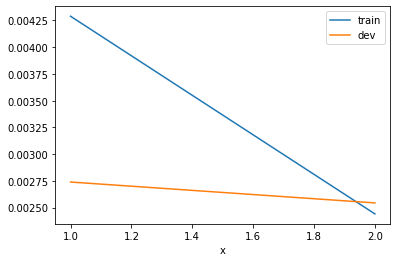

In [19]:
pd.DataFrame({'x':list(range(1, len(train_losses) + 1)), 'train':train_losses, 'dev':test_losses}).plot(x='x')

In [20]:
def calculate_confusion_matrix(features, model, batch_size):
    ''' Calculate the confusion matrix for the labels of the model '''
    
    model.cuda()
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features)):
            # add batch to gpu
            batch = tuple(t.to('cuda') for t in batch)
            b_input_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids)
            predictions.append((torch.sigmoid(raw_outputs) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)
    
def print_pct_correct(features, model):
    tmp = calculate_confusion_matrix(features, model, 80)
    print(f'Percentage correct {((tmp[1] == tmp[2]).astype(int).sum(1) == 12).sum() / tmp[1].shape[0]}')    

In [21]:
print_pct_correct(train_features, model)

Percentage correct 0.7281931464174455


In [22]:
print_pct_correct(test_features, model)

Percentage correct 0.67390625


### Evaluation

In [23]:
def load_model(filename, folder=root_folder):
    ''' Load the save model '''
    
    model = RoBERTaFull(len(train.columns) - 2)
        
    if n_gpu != 0:
        state = torch.load(os.path.join(folder, filename))        
        model.load_state_dict(state)        
        model.cuda()
    else:
        state = torch.load(os.path.join(folder, filename), map_location=torch.device('cpu'))             
        model.load_state_dict(state)
      
    return model

def calculate_confusion_matrix(features, model, batch_size):
    ''' Calculate the confusion matrix from a trained model '''
    
    model.eval()
    torch.cuda.empty_cache()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features, batch_size, False, False)):
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
            
            logger.info(f'Step {step}')
            b_input_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids)
            predictions.append((torch.sigmoid(raw_outputs) > .5).cpu().numpy().astype(int))
            true_labels.append(b_labels.cpu().numpy().astype(int))

        true_labels = np.vstack(true_labels)[0:(batch_size * len(predictions)),]
        predictions = np.vstack(predictions)

        return (multilabel_confusion_matrix(true_labels, predictions),
                true_labels,
                predictions)

def calculate_predictions(features, model, batch_size):
    ''' Calculate the prediction from a trained model '''
    
    if n_gpu != 0:
        model.cuda()
        torch.cuda.empty_cache()

    model.eval()
    result = None

    with torch.no_grad():
        for step, batch in enumerate(create_data_loader(features, batch_size, False, False)):
            logger.info(f'Step {step}')
            
            # add batch to gpu
            if n_gpu != 0:
                batch = tuple(t.to('cuda') for t in batch)
                
            b_input_ids, b_labels = batch
        
            # forward pass
            raw_outputs = model(b_input_ids)
            predictions = torch.sigmoid(raw_outputs[2]).cpu()
            predictions = predictions.numpy()
            result = predictions if result is None else np.append(result, predictions, axis=0)
            
        return result

def get_label_columns(data_frame):
    ''' Return the columns with labels from the dataframe '''
    return [c for c in data_frame.columns if c not in ('Id', 'Text') and '_Pred' not in c]

def add_predictions(data_frame, features, model, batch_size):
    ''' Calculate and add the predicted values to the dataframe '''
    
    logits = calculate_predictions(features, model, batch_size)
    predictions = (logits > .5).astype(int)
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]

def add_predictions_to_dataframe(data_frame, predictions):
    ''' Add the model prediction to the dataframe '''
    
    for i, column_name in enumerate(get_label_columns(data_frame)):
        data_frame[f'{column_name}_Pred'] = predictions[:, i]
        
class ModelResult:
    ''' Helper class used to make prediction from a trained model '''
    
    def __init__(self, data_frame, features, model, batch_size):
        confusion_matrix, labels, predictions = calculate_confusion_matrix(features, model, batch_size)
        self.confusion_matrix = confusion_matrix
        self.labels = labels
        self.predictions = predictions
        self.label_columns = get_label_columns(data_frame)
        
    def save(self, filename):
        ''' Save the model results (this object) to disk '''
        save_object(filename, self)
        
    def get_classification_report(self, output_dictionary):
        ''' Return the classification report from the model predictions '''
        
        return classification_report(self.labels, self.predictions, 
                                     target_names=self.label_columns, 
                                     output_dict=output_dictionary)
        
    def get_results_dataframe(self):
        ''' Create a summary dataframe with the results from the model '''
        
        report_dict = self.get_classification_report(True)
        label_columns = list(self.label_columns)
        label_columns.append('weighted avg')
        classification_results = pd.DataFrame({'Label':label_columns})
        classification_results['Precision'] = [report_dict[c]['precision'] for c in label_columns]
        classification_results['Recall'] = [report_dict[c]['recall'] for c in label_columns]
        classification_results['F1-Score'] = [report_dict[c]['f1-score'] for c in label_columns]
        classification_results['Support'] = [report_dict[c]['support'] for c in label_columns]
        classification_results.loc[classification_results['Label'] == 'weighted avg', 'Label'] = 'Weighted Average'
        
        return classification_results

In [25]:
model = load_model('roberta_dpcnn.pt', '../roberta')
model_results = ModelResult(test, test_features, model, 100)

In [26]:
model_results.save('roberta_dpcnn_result_test.pkl')

In [27]:
model_results = load_object('roberta_dpcnn_result_test.pkl')

In [28]:
add_predictions_to_dataframe(test, model_results.predictions)

<ipython-input-23-a2b666404bc3>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[f'{column_name}_Pred'] = predictions[:, i]


#### Display the evaluation results

<AxesSubplot:ylabel='Frequency'>

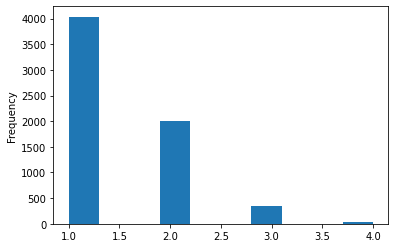

In [29]:
test[get_label_columns(test)].sum(1).plot.hist()

In [30]:
model_results.get_results_dataframe()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Label,Precision,Recall,F1-Score,Support
0,World,0.777102,0.865688,0.819007,886
1,Washington,0.770580,0.769542,0.770061,742
2,New_York_and_Region,0.904185,0.898741,0.901455,1827
3,Front_Page,0.570707,0.395105,0.466942,286
4,Business,0.898053,0.912689,0.905312,859
5,US,0.779331,0.794402,0.786794,1965
6,Sports,0.981381,0.964581,0.972909,1694
7,Obituaries,0.978261,0.996310,0.987203,271
8,Health,0.671687,0.738411,0.703470,302
9,Education,0.530120,0.564103,0.546584,78


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:ylabel='Label'>

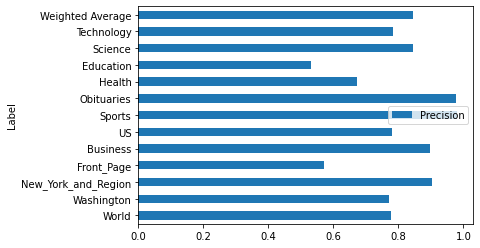

In [31]:
model_results.get_results_dataframe().plot.barh(x='Label', y='Precision')

#### Number of matches

<AxesSubplot:ylabel='Frequency'>

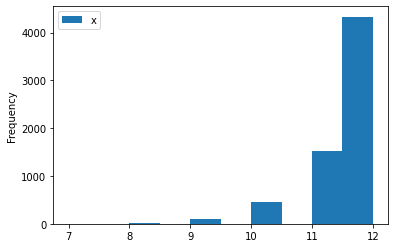

In [32]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

### Training results

In [ ]:
model_results_train = ModelResult(train, train_features, model, 100)

In [ ]:
model_results_train.save('roberta_dpcnn_result_train.pkl')
model_results_train = load_object('roberta_dpcnn_result_train.pkl')

In [ ]:
model_results_train.get_results_dataframe()

In [ ]:
model_results_train.get_results_dataframe().plot.barh(x='Label', y='Precision')

#### Number of matches

In [ ]:
pd.DataFrame({'x':((model_results.labels == model_results.predictions).astype(int).sum(1))}).plot.hist()

## Saving the model

* [pytorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

* [Google Drive](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=D78AM1fFt2ty)

## Bert

* [Bert Tutorial (Hidden Layers)](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

* [GIT Huggingface](https://github.com/huggingface/transformers/blob/master/transformers/modeling_bert.py)